In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import numpy as np
import nltk
from nltk.tokenize.casual import casual_tokenize as tokenizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import operator
import re
import itertools
from sklearn.metrics.pairwise import euclidean_distances
from random import randint

In [3]:
# import Original data
OG_data = pd.read_csv('Vigiglobe2-1.csv')

In [59]:
# import all 13 files 
# some files broken, import manually
all_files = []
l = list(range(1, 13))
for i in l: 
    j = 'IRAhandle_tweets_'+ str(i) + '.csv'
    all_files.append(j)
all_files

frame = pd.DataFrame()
list_ = []
for file in all_files:
    df = pd.read_csv(file)
    list_.append(df)
    print(file)
frame = pd.concat(list_)

IRAhandle_tweets_1.csv
IRAhandle_tweets_2.csv
IRAhandle_tweets_3.csv
IRAhandle_tweets_4.csv
IRAhandle_tweets_6.csv
IRAhandle_tweets_7.csv


/Users/helene/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


IRAhandle_tweets_12.csv
IRAhandle_tweets_13.csv


In [235]:
# import if other import doens't work
f = pd.read_csv('IRAhandle_tweets_1.csv')
s = pd.read_csv('IRAhandle_tweets_2.csv')
t = pd.read_csv('IRAhandle_tweets_3.csv')
fo = pd.read_csv('IRAhandle_tweets_4.csv')
fi = pd.read_excel('IRAhandle_tweets_5_XL.xls')
si = pd.read_csv('IRAhandle_tweets_6.csv')
se = pd.read_csv('IRAhandle_tweets_7.csv')
ei = pd.read_csv('IRAhandle_tweets_8.csv')
ni = pd.read_csv('IRAhandle_tweets_9.csv')
ten = pd.read_excel('IRAhandle_tweets_10_XL.xls')
el = pd.read_csv('IRAhandle_tweets_11.csv')
tw = pd.read_excel('IRAhandle_tweets_12_XL.xlsx')
th = pd.read_csv('IRAhandle_tweets_13.csv')
frames = pd.concat([f, s, t, fo, fi, si, se, ei, ni, ten, el, tw, th])

In [5]:
# creates a set of all account names in the brexit and bot data set
# make everything lower case as bot data is caps only

screen_names = set(list(OG_data['screen_name']))
russia_acc = set(list(frames['author']))
russia_acc_low = [x.lower() for x in russia_acc]
screen_name_low = [str(x).lower() for x in screen_names]
OG_data['screen_name_low'] = OG_data['screen_name'].str.lower() # make name in OG date lowerstring 

In [6]:
# create list of all bots account in brexit data
# it is all lower case. remember when merging
# loops over the brexit account names and adds the ones that are in the bot data to a list
# output is list containing all bot accounts in the brexit data
bot_acc = []
for i in screen_name_low:
    if i in russia_acc_low:
        bot_acc.append(i) # list of bots in data set

In [7]:
# brexit data with binary bot column
bot_df = pd.DataFrame(bot_acc)
bot_df['bot'] = 1 
bot_df.columns = ['screen_name_low', 'bot'] # dataframe with all UK accoutns that are bots
OG_data_bots = OG_data.merge(bot_df, "left", on = 'screen_name_low') # OG data with bot column

In [252]:
# russia data set
frames['screen_name_low'] = frames['author'].str.lower()
# only select russian accounts that are in Brexit data, otherwise later too big to merge
russia_UK_bots = frames.merge(bot_df, "left", on = 'screen_name_low') # russia data with bot column for UK accounts
russia_UK_bots = russia_UK_bots[russia_UK_bots['bot'] == 1] # keep only accounts that are also in brexit data

Problem with merging the russia and brexit tweets: the text is different - can't find common texts

when selecting only the accounts in the russia bot df that are also brexit accounts there are still 923k tweets left in the russia df. But: only 778 of those tweets are also in the brexit data. 

In [11]:
# found two NA values in text from the orgiginal data. should have deleted at the beginning but didnt see therefore deleting now
OG_data_bots = OG_data_bots[OG_data_bots['text'].notnull()]
# counts: number of times tweet appears, ergo number of times tweet gets retweeted or reposted
counts = pd.DataFrame(OG_data_bots.groupby('text').size().reset_index(name='counts'))
# merge counts data frame to OG data frame
OG_data_bots = OG_data_bots.merge(counts, 'left', on = 'text')

# bot: binary column with 1 if it's a bot account and 0 if not
OG_data_bots['bot'].fillna(0, inplace=True)

In [23]:
# identify person who first tweeted
# data sorted by tweet and time, and only person who first posted the tweet is marked as the original tweeter
# or when it has 0 retweets it is an original poster as well 
OG_tweeter = OG_data_bots.sort_values(['text', 'timestamp']).groupby('text').nth(0).reset_index()
OG_tweeter['OG'] = 1
OG_tweeter.loc[OG_tweeter['retweets'] >0, 'OG'] = 0
OG_tweet = OG_tweeter[['text', 'screen_name', 'OG']]

In [26]:
# add the OG poster column to the data
bots = OG_data_bots.merge(OG_tweet, how = 'left', on = ['text', 'screen_name'])
# replace NA with 0 and add that if retweets = 0 then OG = 1 (normally not needed but just to make sure)
bots['OG'].fillna(0, inplace=True)
bots.loc[bots['retweets'] == 0, 'OG'] = 1

In [41]:
# save the new data set 
bots_UK_russia_csv = bots.copy()
bots_UK_russia_csv['text'] = bots_UK_russia_csv['text'].str.replace('\r', ' ')
bots_UK_russia_csv.to_csv('bots_UK_russia.csv', index = False)

# EDA UK

In [42]:
# data set with only bots
only_bots = bots[bots['bot'] == 1]
only_bots['date'], only_bots['time'] = only_bots['timestamp'].str.split('T',1).str
only_bots['date'] = pd.to_datetime(only_bots['date'])

### Number of OG tweets and retweets for bots

In [64]:
# how many are OG tweets
print(' Bot as OG tweeter:', len(only_bots[only_bots['OG'] == 1]), 'Bot as Retweet:', len(only_bots[only_bots['OG'] == 0]))

 Bot as OG tweeter: 441 Bot as Retweet: 317


### Number of tweets, retweets and reposts of bots over timeperiod

In [55]:
# plot the bots
def time_barplot (data, timeperiode):
    # for timeperiode put in "month" or "week"
    if timeperiode == 'day':
        p = ''
    if timeperiode == 'month':
        p = '%m'
    if timeperiode == 'week':
        p = '%U'

    ax = data.groupby(['bot', data['date'].dt.strftime(p)])['date'].count().unstack(0).plot.bar(title="Number of bots per " + timeperiode, figsize=(14,8))
    _ = ax.set_xlabel(timeperiode)
    _ = ax.set_ylabel('bot count')
    mylabels = ['bot', 'bot']
    _ = ax.legend(labels=mylabels)
    plt.show()

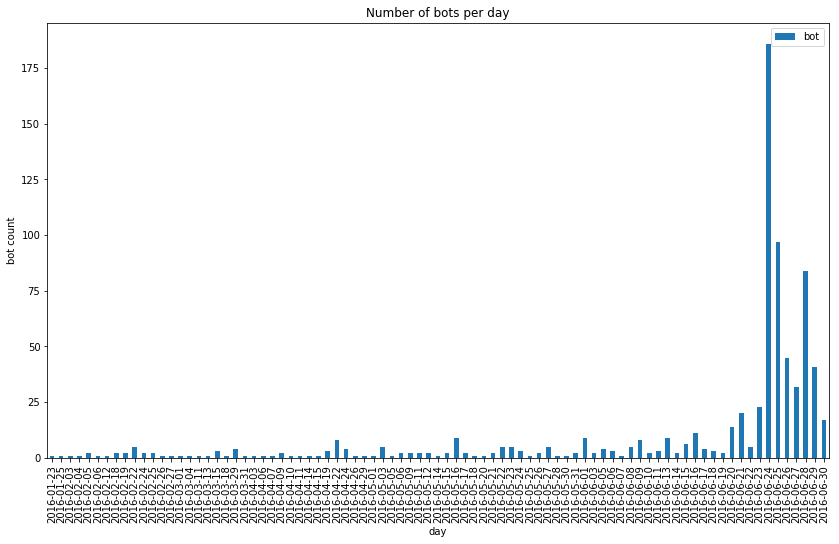

In [68]:
time_barplot(only_bots, 'day')

[Interesing to see that highest bot activity happened after the brexit vote. ]

### Number of bots per timeperiod devided into OG or not retweet

In [148]:
# original poster versus retweeter
def OG_barplot (data, timeperiode):
    # for timeperiode put in "month" or "week"
    if timeperiode == 'day':
        p = ''
    if timeperiode == 'month':
        p = '%m'
    if timeperiode == 'week':
        p = '%U'

    ax = data.groupby(['OG', data['date'].dt.strftime(p)])['date'].count().unstack(0).plot.bar(title="Number of bots per " + timeperiode, figsize=(14,8))
    _ = ax.set_xlabel(timeperiode)
    _ = ax.set_ylabel('bot count')
    mylabels = ['retweet', 'OG tweeter']
    _ = ax.legend(labels=mylabels)
    plt.show()

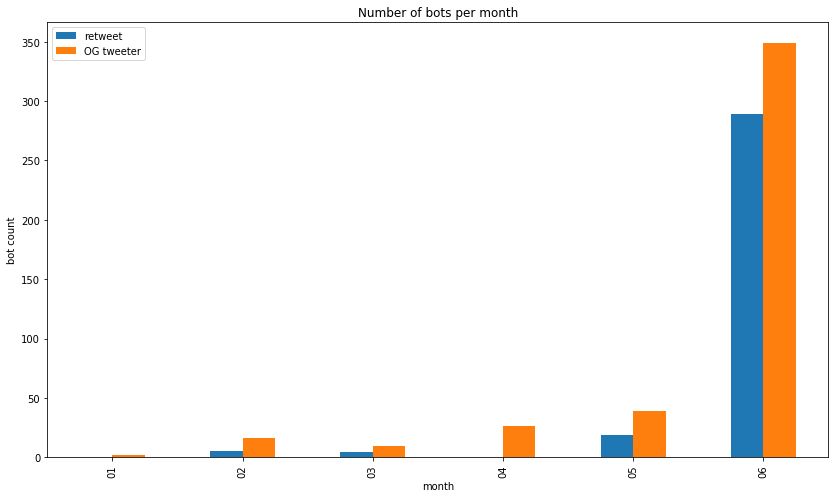

In [150]:
OG_barplot(only_bots, 'month')

### Retweets and reposts across bot and not bot accounts

[When saying that a bot is involved in the communication I mean that a bot has either started a tweet or retweeted a tweet]

In [67]:
# average number of retweets/reposts 
print('average number of retweets/reposts when bot is OG tweeter:',
     round(np.mean(only_bots['counts'][only_bots['OG'] == 1]), 2))
print('average number of retweets/reposts when bot is not OG tweeter, but bot involved in communication:',
     round(np.mean(only_bots['counts'][only_bots['OG'] == 0]), 2))
print('average number of retweets/reposts across whole data set',
     round(np.mean(bots['counts']), 2))

average number of retweets/reposts when bot is OG tweeter: 9.6
average number of retweets/reposts when bot is not OG tweeter, but bot involved in communication: 305.38
average number of retweets/reposts across whole data set 889.55


### Bot account total activity

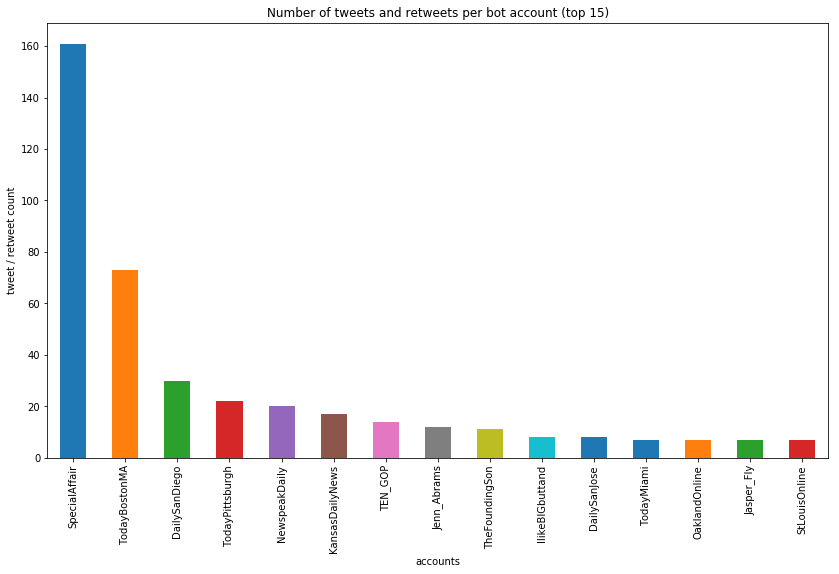

In [86]:
# number of tweets and retweets per bot account
ax = only_bots['screen_name'].value_counts().sort_values(ascending = False)[:15].plot.bar(title="Number of tweets and retweets per bot account (top 15)", figsize=(14,8))
_ = ax.set_xlabel('account name')
_ = ax.set_ylabel('tweet / retweet count')
plt.show()

### Original tweet vs. retweet per bot accounts

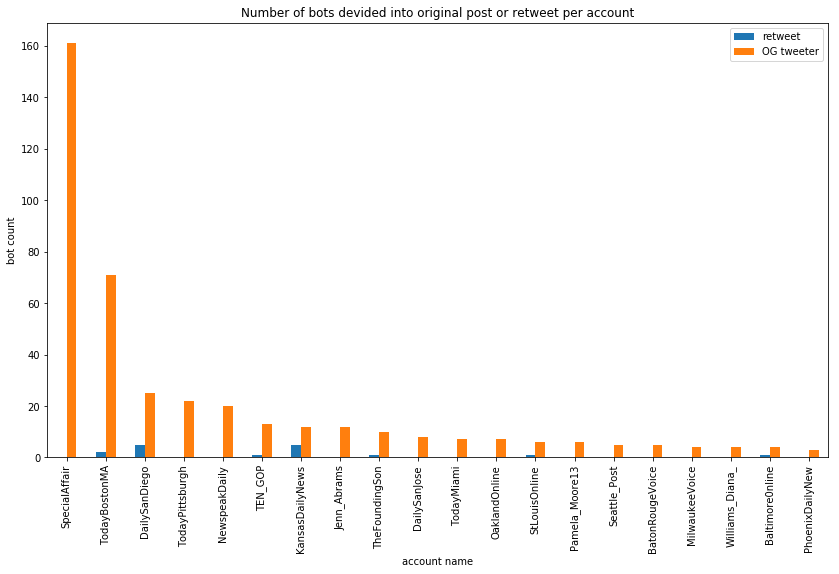

In [143]:
## number of tweets or retweets per bot account
# if sort_values(1.0,ascending = False) is replaced with sort_values(0.0,ascending = False) values are sorted by retweets
ax = only_bots.groupby(['OG', 'screen_name'])['screen_name'].count().unstack(0).sort_values(1.0,ascending = False)[:20].plot.bar(title="Number of bots devided into original post or retweet per account", figsize=(14,8))
_ = ax.set_xlabel('account name')
_ = ax.set_ylabel('bot count')
mylabels = ['retweet', 'OG tweeter']
_ = ax.legend(labels=mylabels)
plt.show()

In [165]:
# add a counter for the number of accounts with the tweet that are bot accounts. 
# wuth that i can see how much of the traffic of a bot was generated by another bot
bot_count = pd.DataFrame(only_bots.groupby('text').size().reset_index(name='bot_count'))
only_bots = only_bots.merge(bot_count, 'left', on = 'text')
only_bots['bot_traffic'] = only_bots['bot_count'] / only_bots['counts']

### mean percentage of bot traffic due to bots

In [169]:
print('mean percentage of bot traffic due to bots, ergo how many of the bots retweets are due to bots', 
     round(np.mean(only_bots['bot_traffic']), 2))
print('mean percentage of bot traffic when bot original post due to bots, ergo how many of the bots retweets are due to bots', 
     round(np.mean(only_bots['bot_traffic'][only_bots['OG'] == 1]), 2))

mean percentage of bot traffic due to bots, ergo how many of the bots retweets are due to bots 0.6
mean percentage of bot traffic when bot original post due to bots, ergo how many of the bots retweets are due to bots 0.78


# Clustering UK Bots

In [170]:
# tokenising, removing stopwords, hyperlinks and direct mentions

tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
def __cleanText(text):
    global txt, all_words_clean, all_words_clean_og, txt2 
    all_words = []
    txt = []
    for line in text:
        sent = line.lower()
        sent = tknzr.tokenize(sent)
        all_words.extend(sent)
        txt.append(sent)
    stop = list(stopwords.words("english"))
    stop.extend(['...', 'http', 'https', 'rt'])
    all_words_clean = []
    for word in all_words:
        if (word not in stop) and (len(word) >= 2) and (word[0:4]!='http'):
            all_words_clean.append(word)
            
    all_words_clean_og = set(all_words_clean) # all_words_clean: set of all words that appear in corpus; cleaned
    
    txt2 = txt[:] # txt2: list of  tweets. Each sublist is one tweet and each word in the tweet is one seperate string. 
    

# remove all words from tweets that are not in all_words_clean_og
# input: tweets is a list of list of tweets with tokenized words: here txt2
# output: tweets_clean: list of list where each list is one cleaned tweet as one string
def __cleanTweet(tweets): 
    global tweets_clean
    tweets_clean = []
    for i in tweets:
        resultwords  = [word for word in i if word in all_words_clean_og]
        result = ' '.join(resultwords)
        tweets_clean.append([result]) 

In [171]:
#clean text and make word vectors with tfidf 
#if tfidf not wanted just leave out code part and use X instead 

def __word_vector_tfidf(all_words_clean, text, txt):
    # all_words_clean: list of all words cleaned 
    # text: list of tweets. for the relevant data make list of 'text' column text = list(data.text).
    # txt: tokneized words list of list
    
    global X_tfidf, tfidf_transformer, X, all_words_clean2

    all_words_clean2 = nltk.FreqDist(all_words_clean)
    word_features = list(all_words_clean2)
    noX = len(text)
    noFeatures = len(word_features)
    X = np.zeros((noX, noFeatures))

    for i in range(noX):
        line = txt[i]
        for j in range(noFeatures):
            word = word_features[j]
            if word in line:
                X[i][j] = 1
                
    # apply tdidf weighting to bag of words word vector  
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X)


In [182]:
def __find_k(X_tfidf):
    # X_tfidf: sparse weighted word vector matrix from tfidf_transformer

    # k means determine k
    X_tfidf_array = X_tfidf.A   #make sparse matrix an array for plotting
    distortions = []
    K = range(1,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X_tfidf)

        distortions.append(sum(np.min(cdist(X_tfidf.A, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_tfidf.shape[0])
 
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Optimal k, month:')
    plt.show()

In [173]:
def __cluster_km(num_clusters, X_tfidf):
    # num_cluster: best number of clusterst based on elbow plot 
    # make the clusters based on the X_tfidf matrix
    global frame, km, clusterkm, clusters, frame_clean
    km = KMeans(n_clusters = num_clusters, random_state = 1)
    km.fit(X_tfidf )

    clusterkm = km.cluster_centers_

    clusters = km.labels_.tolist()

    # adds cluster number to each tweet in data

    frame = pd.DataFrame(text, columns = ['tweet_' + month])
    frame['cluster' + month] = clusters # adds the cluster number to the tweets in the data. 
   
    frame_clean = pd.DataFrame(tweets_clean, columns = ['tweet_' + month])
    frame_clean['cluster' + month] = clusters # same data frame with cluster for each tweet but displays the cleaned tweet. less readible

In [255]:
# distinct tweets is a data frame that groups all tweets in the clusters 
# by the tweets and counts their frequency in each cluter
# example: tweet 'hello vote_leave' apprears 5 times and 'vote_leave 4 every' 2 times in cluster 1
# there are 2 distinct tweets in cluster 1

def __distinct_tweets(frame): 

    global distinct_tweets
    distinct_tweets = pd.DataFrame(frame.groupby([('tweet_'+month), ('cluster'+month)]).size().nlargest(60).reset_index(name='counts')).sort_values(["cluster"+month, "counts"], ascending = [True, False])

    pd.options.display.max_colwidth = 130
    return distinct_tweets

In [191]:
def __tweets_per_cluster_summary(clusters, frame, km, X_tfidf, month, distinct_tweets, side_month, clusterkm):
    # where km is the model and X_tfidf is a word vector matrix
    # distinct_tweets the df with distinct tweets, cluster and count
    # side_month the origninal data frame for the given month
    # clusterkm = km.cluster_centers_
    # clusters = km.labels_.tolist() list of the cluster number for each tweet
    
    global cluster_summary, summary, cluster_dist, cluster_inertia
    clusters = km.labels_.tolist()
    cluster_df = pd.DataFrame(clusters)
    count = pd.DataFrame({"number_tweets": cluster_df[0].value_counts()}) # number of tweets in each cluster
    unique = frame.groupby('cluster'+month).nunique() # number of different tweets in each cluster
    unique2 = pd.DataFrame(unique.iloc[:,0])
    cluster_summary = pd.merge(count, unique2, left_index=True, right_index=True)
    # summary with number of tweets and number of distinct tweets in each cluster
    
    # now add within-cluster distance (=inertia) for each cluster
    # inertia per cluster
    distances = km.fit_transform(X_tfidf) # Compute clustering and transform X_tfidf to cluster-distance space.
    inertia_df = pd.DataFrame(distances)
    inertia_df['label'] = km.labels_
    inertia_df['dist'] = ""
    for row in range(len(inertia_df)):
        l = inertia_df['label'][row]
        inertia_df.loc[row, 'dist'] = inertia_df[l][row]
    # inertia_df # selects the distance from each point to it's cluster centroid
    cluster_inertia = pd.DataFrame(inertia_df.groupby(['label'])['dist'].sum()) # returns cluster inertia for each cluster
    cluster_summary = pd.merge(cluster_summary, cluster_inertia, left_index=True, right_index=True)
    cluster_summary['cluster'+month] = cluster_summary.index
    cluster_summary = cluster_summary.rename(columns = {'tweet_'+month:'distinct_tweets'})
    # cluster_summary: summary including the number of tweets, number of distinct tweets and the within-cluster distance 
    
    
    
    #cross table with distances between each cluster
    cluster_dist = pd.DataFrame(euclidean_distances(clusterkm))
    cluster_dist['distance_sum'] = cluster_dist.sum(axis = 0)

In [178]:
# for random week prep data and then run the find k functinon
month = 'all'
text = list(only_bots.text)
__cleanText(text)
__cleanTweet(txt2)
__word_vector_tfidf(all_words_clean, text, txt)

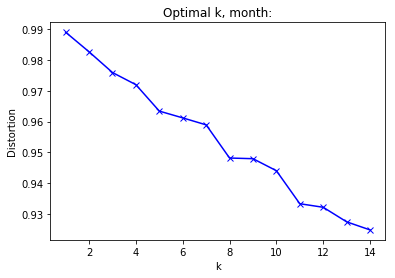

In [183]:
__find_k(X_tfidf)

In [256]:
k = 8

In [257]:
__cluster_km(k, X_tfidf)
__distinct_tweets(frame)
__tweets_per_cluster_summary(clusters, frame, km, X_tfidf, month, distinct_tweets, only_bots, clusterkm)

In [258]:
display(cluster_summary.sort_values('cluster'+month), distinct_tweets) 

,number_tweets,distinct_tweets,dist,clusterall
0,176,87,171.842238,0
1,113,86,108.994230,1
2,51,37,48.129935,2
3,93,84,86.251555,3
4,21,4,13.670846,4
5,147,106,144.154601,5
6,36,8,31.777576,6
7,121,112,117.462350,7


,tweet_all,clusterall,counts
1,"Don't fret if you hear 2 sheets of blood covered sandpaper being scraped today, it's just Rupert Murdoch rubbing his hands tog...",0,7
2,"how am i going to afford my fitness gram pacer test now, #brexit?",0,7
3,Congratulations to my @HuffPostUK friends on this AMAZING headline. Bravo. Bravo. Bravo. #Brexit,0,6
5,More than 1 million sign online petition demanding a second EU referendum after #Brexit vote.,0,6
6,The next #Brexit question - who'll invest $130 billion to keep Britain's lights on?,0,6
9,"""There are lies, damned lies, and statistics."" An economist's guide to #Brexit",0,5
10,#Brexit live: Jeremy Corbyn loses no confidence motion #Labour\n\n,0,5
14,A vote against Brexit isn't the end of Brexit. Just the opposite.,0,5
19,Everybody is obsessed with #EUref today\nSo let's play #ReasonsToLeaveEU,0,5
20,"GLOBAL MARKETS-Brexit fears drag on world stocks, boost yen: * Sterling down broadly, oil dro... via @josephjett",0,5


In [260]:
# number of words used for clustering across the whole corpus
len(all_words_clean_og)

1484

### most frequent hashtags

In [224]:
def top_tag(data): # for data you can put the full data set, the specific month etc
    global top_tags, top_tags_df, text_full_data
    text_full_data = list(data["text"])
    top_tags = []
    for tweet in text_full_data:
        tag = re.findall(r"#(\w+)", str(tweet))
        top_tags.append(tag)
    
    top_tags_df = pd.DataFrame(list(Counter(i for i in list(itertools.chain.from_iterable(top_tags))).items()))
    top_tags_df.columns = ['hashtag', "count"]
    top_tags_df = top_tags_df.sort_values('count', ascending = False).reset_index(drop = True)

# frequency chart of most used hashtag 

def plot_tag_occ (data, plot_title): 
    # for plot title insert plot title as string

    top_tag(data)
    counts = dict(Counter(i for i in list(itertools.chain.from_iterable(top_tags))).most_common(15))

    labels, values = zip(*counts.items())

    # sort your values in descending order
    indSort = np.argsort(values)[::-1]
    
    # rearrange your data
    labels = np.array(labels)[indSort]
    values = np.array(values)[indSort]

    indexes = np.arange(len(labels))

    bar_width = 0.35

    plt.bar(indexes, values)

    # add labels
    plt.xticks(indexes + bar_width, labels, rotation='vertical')
    plt.title(plot_title) # change that title
    plt.show()

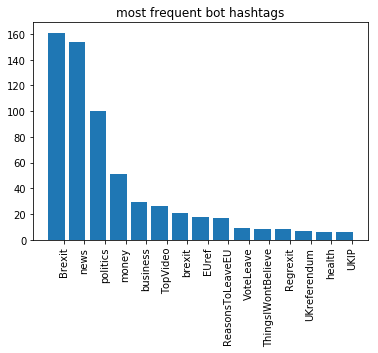

In [225]:
plot_tag_occ (only_bots, 'most frequent bot hashtags')

# US

In [217]:
US_fake_news = pd.read_csv('US_one_month.csv')
US_fake_news['screen_name_low'] = US_fake_news['user_screen_name'].str.lower() # make name in OG date lowerstring 

In [218]:
screen_names_US = set(list(US_fake_news['screen_name_low']))
# create list of all bots account in brexit data
# it is all lower case. remember when merging
bot_acc_US = []
for i in screen_names_US:
    if i in russia_acc_low:
        bot_acc_US.append(i) # list of bots in data set

bot_acc_US

['southlonestar', 'crystal1johnson', 'ten_gop', 'pamela_moore13']

In [219]:
bot_df_US = pd.DataFrame(bot_acc_US)
bot_df_US['bot'] = 1
bot_df_US.columns = ['screen_name_low', 'bot']
US_bots = US_fake_news.merge(bot_df_US, "left", on = 'screen_name_low')

In [221]:
US_bots[US_bots['bot'] == 1] 

,tweet_id,created_at,retweet_count,text,user_screen_name,is_fake_news_1,is_fake_news_2,fake_news_category_1,fake_news_category_2,user_verified,...,user_followers_count,user_favourites_count,tweet_source,geo_coordinates_available,num_hashtags,num_mentions,num_urls,num_media,screen_name_low,bot
1511,779855189431967000,Sun Sep 25 01:29:00 +0000 2016,4733,Every time you RT this pic it will notify @HillaryClinton and she will see the face of #Benghazi victim's mom Patri… https://t...,TEN_GOP,NaN,NaN,NaN,NaN,False,...,53875,574,TweetDeck,1,1,2,1,0,ten_gop,1.0
2689,794257640884989000,Thu Nov 03 19:19:12 +0000 2016,1605,Melania Trump gave a campaign speech for her husband @realDonaldTrump: '‘Make America Great Again’ is not just some… https://t...,Pamela_Moore13,NaN,NaN,NaN,NaN,False,...,24578,451,Twitter Web Client,0,0,2,1,0,pamela_moore13,1.0
3394,796053302693822000,Tue Nov 08 18:14:31 +0000 2016,29072,🚨BREAKING: Machine Refuses to Allow Vote For Trump in Pennsylvania!! RT the hell out of it! #VoterFraud #voted… https://t.co...,TEN_GOP,NaN,NaN,NaN,NaN,False,...,52348,564,Twitter Web Client,2,2,1,1,0,ten_gop,1.0
3405,796055138406371000,Tue Nov 08 18:21:49 +0000 2016,1230,This young woman cried after Barack Obama's election in 2008. But how does she feel now 8 years later?… https://t.co/gNS0mc7IZ8,Crystal1Johnson,NaN,NaN,NaN,NaN,False,...,21480,248,Twitter Web Client,0,0,1,1,0,crystal1johnson,1.0
3419,796059451035971000,Tue Nov 08 18:38:57 +0000 2016,1028,Every American has a chance to strengthen our freedom with every vote! #Voted #ElectionDay https://t.co/gfWwQXk9Im,TEN_GOP,NaN,NaN,NaN,NaN,False,...,53055,574,TweetDeck,2,2,1,0,1,ten_gop,1.0
3436,796063894934605000,Tue Nov 08 18:56:37 +0000 2016,1829,🚨BREAKING: reports of #VoterFraud in Philly.. 'Instructional ballot' being handed out inside polling stations‼️… https://t.co/...,TEN_GOP,NaN,NaN,NaN,NaN,False,...,52570,574,TweetDeck,1,1,1,1,0,ten_gop,1.0
3500,796079619971674000,Tue Nov 08 19:59:06 +0000 2016,1119,Show Twitter that high energy ENTHUSIASM is on our side! RT if you #voted for TRUMP! #ElectionDay https://t.co/FeZ5HFgr0p,TEN_GOP,NaN,NaN,NaN,NaN,False,...,52348,564,Twitter Web Client,2,2,1,0,1,ten_gop,1.0
3504,796080813607714000,Tue Nov 08 20:03:51 +0000 2016,1193,This vet passed away last month before he could vote for Trump.. Here he is in his #MAGA hat.. #voted #ElectionDay https://t...,TEN_GOP,NaN,NaN,NaN,NaN,False,...,52348,564,TweetDeck,3,3,1,0,0,ten_gop,1.0
3557,796096570030780000,Tue Nov 08 21:06:27 +0000 2016,1210,🚨VoterFraud: Philly Democrat Judge of Elections inside voting booth with voter‼️ #ElectionDay #IVoted (Via… https://t.co/inxE...,TEN_GOP,NaN,NaN,NaN,NaN,False,...,52350,564,Twitter Web Client,2,2,1,1,0,ten_gop,1.0
3569,796099607189131000,Tue Nov 08 21:18:31 +0000 2016,6747,🚨WOW: another proof of #VoterFraud!! Machine refuses to allow vote for Trump!! RT b/c Media will never report this… https://t...,TEN_GOP,NaN,NaN,NaN,NaN,False,...,52347,564,Twitter Web Client,1,1,1,1,0,ten_gop,1.0


# Mexico

In [212]:
mexico = pd.read_csv('Mexico_tweets.csv')
mexico['screen_name_low'] = mexico['screen_name'].str.lower() # make name in OG date lowerstring 
mexico['screen_name_low'] = mexico['screen_name_low'].replace('@', '', regex=True) # remove @ sign at beginning 

In [247]:
screen_names_mexico = set(list(mexico['screen_name_low']))
# create list of all bots account in brexit data
# it is all lower case. remember when merging
bot_acc_mexico = []
for i in screen_names_mexico:
    if i in russia_acc_low:
        bot_acc_mexico.append(i) # list of bots in data set
bot_acc_mexico


[]